![](https://www.packetpower.com/hs-fs/hubfs/Blog/acronyms.png?width=700&name=acronyms.png) 

As a useful case-study, I was asked to train a classifier that distinguishes between acronyms and initialisms. 

Acronyms are "made up of parts of the phrase it stands for and pronounced as a word." Initialisms are "an acronym that is pronounced as individual letters."  

NASA vs DNA.


### Step 1) Data
Wikipedia has a page with 6800 labeled acronyms [here](https://en.wikipedia.org/wiki/Lists_of_acronyms).  I scraped the data using [Web Scraper](https://www.webscraper.io/) and created a csv with cleaned acronyms, the original Wikipedia description, a label and the CMU pronunciation.  Only 250 of the acronyms were in the CMU dictionary, so I trained a model to automatically generate 950 of them based on [this post](https://www.ryanepp.com/blog/predicting-english-pronunciations) by Ryan Epp.  Only later did I see Ryan's [Big-Phoney](https://www.ryanepp.com/#Big-Phoney) library that accomplishes this task with pre-trained models.   

(a) = acronym, e.g.: SARS – (a) severe acute respiratory syndrome 

(i) = initialism, e.g.: CD – (i) compact disc

(p) = pseudo-blend, e.g.: UNIFEM – (p) United Nations Development Fund for Women

(s) = symbol (none of the above, representing and pronounced as something else; for example: MHz – Megahertz)


In [ ]:
import spacy
import pandas as pd

url = (
    "https://raw.githubusercontent.com/apjanco/spaCy_workshops/master/acronym_data.csv"
)
df = pd.read_csv(url)

# create a list of the labeled acronyms and initialisms. Thank you Wikipedia!
acronyms = []
initialisms = []
pseudo_blend = []
symbols = []

for i in range(len(df)):
    if df["label"][i] == "a":
        acronyms.append(df["acronym"][i])
    if df["label"][i] == "i":
        initialisms.append(str(df["acronym"][i]))
    if df["label"][i] == "p":
        pseudo_blend.append(str(df["acronym"][i]))
    # if df['label'][i] == 's':
    #    symbols.append(str(df['acronym'][i]))
print(
    "a=", len(acronyms), "i=", len(initialisms), "p=", len(pseudo_blend),
)  #'s=',len(symbols) )

In [ ]:
# Let's establish a simple baseline. If we just check that a word is capitalized and longer than three charachters, is that an acronym?
def is_acronym(word: str):
    score = 0
    if word.isupper():
        score += 1
    if len(word) >= 3:
        score += 1
    # TODO acronym resembles an existing real word

    if score == 2:
        return True
    else:
        # print(word)
        return False

In [ ]:
count = 0
for acronym in acronyms:
    if is_acronym(acronym):
        count += 1
print(count / len(acronyms))

Not bad.  There are zero acronyms shorter than three characters and we match 95% of our gold data. We're only matching when the entire word is in capitals.  Try adding or changing the rules to improve this.   

In [ ]:
# However, these rules are just as good at finding initialisms.  But how to differentiate them?
count = 0
for initialism in initialisms:
    if is_acronym(initialism):
        count += 1
print(count / len(initialisms))

In [ ]:
# Perhaps if we look at pronunciation there are good features to distinguish the two?
from big_phoney import BigPhoney

phoney = BigPhoney()
acronym_syl = []
initialism_syl = []
for acronym in acronyms:
    acronym_syl.append(len(phoney.phonize(acronym)))
for initialism in initialisms:
    initialism_syl.append(len(phoney.phonize(initialism)))

In [ ]:
#I tried number of syllables, and length of pronunciation.  They were no help in distinguishing initialisms from other acronyms.
# What would you try? 

def is_acronym(word: str):
    pass

In [ ]:
url = (
    "https://raw.githubusercontent.com/apjanco/spaCy_workshops/master/acronym_data.csv"
)
df = pd.read_csv(url)
df = df[df.label != "s"]


def is_correct(label, gold_label):

    if label == "INITIALISM":
        if gold_label == "i":
            return True
        else:
            return False

    if label == "ACRONYM":
        if gold_label == "a":
            return True
        else:
            return False

    if label == "PSEUDO":
        if gold_label == "p":
            return True
        else:
            return False


results = {
    "initialisms": {"correct": 0, "total": 0},
    "acronyms": {"correct": 0, "total": 0},
    "pseudo": {"correct": 0, "total": 0},
}

for i in range(len(df)):
    try:
        if is_acronym(df["acronym"].iloc[i]):
            if df["label"].iloc[i] == "a":
                results["acronyms"]["correct"] += 1
            results["acronyms"]["total"] += 1
    except AttributeError:
        continue

        # print(ent, ent.label_, df['label'].iloc[i], correct)

In [ ]:
print(results)
results["acronyms"]["correct"] / results["acronyms"]["total"]

## Yikes! While we're able to find acronyms, we're not discerning between acronyms and initialisms. 

##  To train a spaCy model, we'll need some training texts so that the model can learn to distinguish between a and i in context. 
I first tried this dataset: https://github.com/mhjabreel/CharCnn_Keras/tree/master/data/ag_news_csv
```python
url="https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv"
test_data = pd.read_csv(url, header=None,names=['category', 'headline', 'text'])
```
But I could not use it because it has no examples of acronym, only initialism.

In [1]:
# This is a much larger dataset, the Blogger Corpus, with 681,288 blog posts collated from blogger.com. Each blog contains at least 200 occurrences of frequently used English words.
#!wget http://www.cs.biu.ac.il/~koppel/blogs/blogs.zip
#!unzip blogs.zip
#import os
#files = os.listdir("./blogs")

# Step 2) Create text training data.  I need to identify sentences in this large corpus that contain acronyms.  

When creating training data, you can use either the Matcher or the PhraseMatcher.  The matcher will use Token-level attributes to search and identify what you're looking for. You need to write the specific rules for the match.  The PhraseMatcher takes a Doc object as input.  Given that we're basically searching for strings in our list of acronyms, we could also search with Python, but spaCy is faster and gives us the ability to easily get the sentence where the acronym appears.     

Further details on Matcher and PhraseMatcher can be found in Chapter 4 of the [spaCy course](https://course.spacy.io/chapter4)


## [Rule-based Matcher Explorer](https://explosion.ai/demos/matcher)
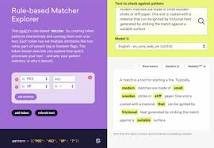




In [ ]:
# Import the PhraseMatcher and initialize it
nlp = spacy.load("en_core_web_sm")
from spacy.matcher import PhraseMatcher

matcher = PhraseMatcher(nlp.vocab)

# Create pattern Doc objects and add them to the matcher

a_patterns = list(nlp.pipe(acronyms))
matcher.add("ACRONYM", None, *a_patterns)

i_patterns = list(nlp.pipe(initialisms))
matcher.add("INITIALISM", None, *i_patterns)

p_patterns = list(nlp.pipe(pseudo_blend))
matcher.add("PSEUDO", None, *p_patterns)


### In this cell, we search for acronyms in the text data.  We create a list of sentences with acronyms in them.
This takes about four hours, so I'll save you the time.  You can load the text as a pickle below. 
```python
from tqdm import tqdm
TEXTS = []
nlp.max_length = 2000000
for file in tqdm(files):
    with open(''.join(['./blogs/', file]),'r') as f:
        try:
            doc = nlp(str(f.read()))
            matches = matcher(doc)
            for match in matches:
                sentence = doc[match[1]].sent.text  #Note that this is a Span object, so we need to get the text as a string 
                TEXTS.append(sentence)
        except UnicodeDecodeError:
            continue

100%|██████████| 19320/19320 [4:08:17<00:00,  3.12it/s]  ```

In [ ]:
import pickle

TEXTS = pickle.load(open("TEXTS.pickle", "rb"))

```python
TRAINING_DATA = []
# Create a Doc object for each text in TEXTS
for doc in nlp.pipe(TEXTS):
   
    # Match on the doc and create a list of matched spans
    spans = [(doc[start:end], match_id) for match_id, start, end in matcher(doc)]
    
    # Get (start character, end character, label) tuples of matches
    entities = [(span[0].start_char, span[0].end_char, doc.vocab.strings[span[1]]) for span in spans]

    # Format the matches as a (doc.text, entities) tuple
    training_example = (doc.text, {'entities': entities})
    # Append the example to the training data
    TRAINING_DATA.append(training_example)
```
This one takes some time as well, so we'll skip it for the moment, but please feel free to try it if you like

In [ ]:
import pickle

TRAINING_DATA = pickle.load(open("TRAINING_DATA.pickle", "rb"))

In [ ]:
# Display the number of example sentences per category
initialism_examples = 0
acronym_examples = 0
pseudo_examples = 0
for i in range(len(TRAINING_DATA)):
    text = TRAINING_DATA[i][0]
    entities = TRAINING_DATA[i][1]["entities"]
    for start, stop, label in entities:
        if label == "INITIALISM":
            initialism_examples += 1
        if label == "ACRONYM":
            acronym_examples += 1
        if label == "PSEUDO":
            pseudo_examples += 1
print(
    " acronyms: ",
    acronym_examples,
    "\n",
    "initialisms: ",
    initialism_examples,
    "\n",
    "pseudo: ",
    pseudo_examples,
)

Not bad, with our training data in hand, we can start experimenting

## Experiment No. 1  
In this experiment, we are going to train a classifier using the acronyms and labels from Wikipedia and the news sentences with acronyms. 


```python
import random
from tqdm import tqdm
# Start the training
ner = nlp.get_pipe("ner")
ner.add_label("INITIALISM")
ner.add_label("ACRONYM")
ner.add_label('PSEUDO')

other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
with nlp.disable_pipes(*other_pipes):  # only train NER

    nlp.begin_training()
    # Loop for 10 iterations
    for itn in tqdm(range(10)):
        # Shuffle the training data
        random.shuffle(TRAINING_DATA)
        losses = {}
        
        # Batch the examples and iterate over them
        for batch in spacy.util.minibatch(TRAINING_DATA, size=2):
            texts = [text for text, entities in batch]
            annotations = [entities for text, entities in batch]
            
            # Update the model
            nlp.update(texts, annotations, losses=losses)
            #print(losses)
    nlp.to_disk("/en_acronym_initialism")
```

Depending on the amount of data you use, training can take some time. spaCy is designed for quick experimentation. Try with the least training and data. See how the model learns.  With transfer learning, you'll always be surprised how quickly the model learns.  I have saved the model [here](https://haverford.box.com/s/d38m6t9h6nk6m8r96kqj08rd3f3r05ai)
You can download it and install it with `pip install <the_filename_and_path>`

In [ ]:
import random
from spacy import displacy

data = TRAINING_DATA[random.choice(range(len(TRAINING_DATA)))]
text = data[0]
label = data[1]["entities"]
nlp = spacy.load("en_acronym_initialism")
doc = nlp(text)

colors = {
    "ACRONYM": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "INITIALISM": "linear-gradient(90deg,#fc9ce7,  #aa9cfc)",
    "PSEUDO": "linear-gradient(90deg,#fc9ce7,  #aa9cfc)",
}
options = {"ents": ["ACRONYM", "INITIALISM", "PSEUDO"], "colors": colors}

print(label)
displacy.render(doc, style="ent", jupyter=True, options=options)

In [ ]:
url = (
    "https://raw.githubusercontent.com/apjanco/spaCy_workshops/master/acronym_data.csv"
)
df = pd.read_csv(url)
df = df[df.label != "s"]

nlp = spacy.load("en_acronym_initialism")


def is_correct(label, gold_label):

    if label == "INITIALISM":
        if gold_label == "i":
            return True
        else:
            return False

    if label == "ACRONYM":
        if gold_label == "a":
            return True
        else:
            return False

    if label == "PSEUDO":
        if gold_label == "p":
            return True
        else:
            return False


results = {
    "initialisms": {"correct": 0, "total": 0},
    "acronyms": {"correct": 0, "total": 0},
    "pseudo": {"correct": 0, "total": 0},
}

for i in range(len(df)):
    try:
        doc = nlp(df["acronym"].iloc[i])
        for ent in doc.ents:

            if df["label"].iloc[i] == "i":
                correct = is_correct(ent.label_, df["label"].iloc[i])
                if correct:
                    results["initialisms"]["correct"] += 1
                results["initialisms"]["total"] += 1

            if df["label"].iloc[i] == "a":
                correct = is_correct(ent.label_, df["label"].iloc[i])
                if correct:
                    results["acronyms"]["correct"] += 1
                results["acronyms"]["total"] += 1

            if df["label"].iloc[i] == "p":
                correct = is_correct(ent.label_, df["label"].iloc[i])
                if correct:
                    results["pseudo"]["correct"] += 1
                results["pseudo"]["total"] += 1
    except TypeError:
        print(ent)
        # print(ent, ent.label_, df['label'].iloc[i], correct)

In [ ]:
[
    print(result, results[result]["correct"] / results[result]["total"])
    for result in results
]